If I don't prevent OpenMP threading, I end up with a *ton* of system time from multithreaded BLAS that actually lowers performance:

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
from emcee import EnsembleSampler
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import scipy.linalg as sl
import scipy.stats as ss
import starry
from starry import Map, System, Primary, Secondary
import starry_process
from starry_process import StarryProcess
import theano
import theano.tensor as tt
from theano.tensor.random.utils import RandomStream
from tqdm.notebook import tqdm
from corner import corner

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Formulas:
$$
N\left( f \mid M y, C \right) N\left( y \mid \mu, \Lambda \right) = N\left( y \mid a, A \right) N\left( f \mid b, B \right)
$$
where
$$
A^{-1} = \Lambda^{-1} + M^T C^{-1} M
$$
$$
a = A \left( \Lambda^{-1} \mu + M^T C^{-1} M f \right)
$$
$$
b = M \mu
$$
$$
B = C + M \Lambda M^T
$$

Useful re-writing:
$$
A = \left( I + \Lambda M^T C^{-1} M \right)^{-1} \Lambda
$$

$$
B^{-1} = C^{-1} - C^{-1} M \left( I + \Lambda M^T C^{-1} M \right)^{-1} \Lambda M^T C^{-1}
$$

In [3]:
def _cho_solve(L, b):
    return tt.slinalg.solve_upper_triangular(L.T, tt.slinalg.solve_lower_triangular(L, b))

class StarryStarryProcess(object):
    def __init__(self, sys, sp, nt, nlm):
        self._sys = sys
        self._sp = sp
        self._nt = nt
        self._nlm = nlm

        self._mu = sp.mean_ylm
        self._Lambda = sp.cov_ylm

    @property
    def nt(self):
        return self._nt
    @property
    def nlm(self):
        return self._nlm

    @property
    def sys(self):
        return self._sys
    @property
    def sp(self):
        return self._sp
    
    @property
    def mu(self):
        return self._mu
    @property
    def Lambda(self):
        return self._Lambda
    
    @property
    def primary(self):
        return self.sys.primary
    @property
    def secondary(self):
        return self.sys.secondaries[0]
    
    @property
    def design_matrix(self):
        return self._M

    @property
    def logl_marginal(self):
        return self._logl_marginal
    @property
    def a(self):
        return self._a
    @property
    def AInv_chol(self):
        return self._AInv_chol

    def _compute(self, t, flux, sigma_flux):
        M = self.sys.design_matrix(t)[:,:-1] # We don't use any flux from the secondary, so [:, :-1]
        self._M = M

        nlm = self.nlm
        nt = self.nt

        mu = self.mu
        Lambda = self.Lambda

        # We want to enforce that the prior on the constant term in the map is
        # completely flat, so we set the first row and column of the precision
        # matrix to zero we do this manually here.  First we Cholesky decompose:
        #
        # Lambda[1:,1:] = L L^T
        #
        # Then, because of a quirk of theano (no gradients for `cho_solve!`,
        # WTF), we can compute Lambda[1:,1:]^{-1} via
        #
        # Lambda[1:,1:]^{-1} = tt.slinalg.solve_triangular(L.T, tt.slinalg.solve_triangular(L, tt.eye(nlm-1), lower=True), lower=False)
        #
        # encapsulated in our _cho_solve(...) function above
        L = tt.slinalg.cholesky(Lambda[1:,1:])
        Lambda_inv = _cho_solve(L, tt.eye(nlm-1))
        Lambda_inv = tt.set_subtensor(tt.zeros((nlm, nlm))[1:,1:], Lambda_inv)

        sigma_flux2 = tt.square(sigma_flux)
        MTCinv = M.T / sigma_flux2[None, :]
        MTCinvM = tt.dot(MTCinv, M)

        AInv = Lambda_inv + MTCinvM
        AInv_chol = tt.slinalg.cholesky(AInv)
        a = _cho_solve(AInv_chol, tt.dot(Lambda_inv, mu) + tt.dot(MTCinv, flux))

        self._a = a
        self._AInv_chol = AInv_chol

        b = tt.dot(M, mu)
        r = flux - b

        Cinvr = r / sigma_flux2

        rtilde = Cinvr - tt.dot(MTCinv.T, tt.slinalg.solve(AInv, tt.dot(MTCinv, r)))

        # Identity:
        # |B| = |I + M^T C^-1 M L| |C| = |L^-1 + M^T C^-1 M| |L| |C|
        # But we want to cancel the infinite constant in L[0,0], so we ignore the first row and column of L:
        # |B| = | A^-1 | |L[1:,1:]| |C|

        logdetB = tt.sum(tt.log(sigma_flux2)) + 2*tt.sum(tt.log(tt.diag(AInv_chol))) + 2*tt.sum(tt.log(tt.diag(L)))

        # (nt-1) because we have cancelled one dimension due to the flat prior on the [0,0] constant term.
        logl = -0.5*tt.dot(r, rtilde) - 0.5*logdetB - 0.5*(nt-1)*tt.log(2*np.pi)
        self._logl_marginal = logl

    def marginal_likelihood(self, t, flux, sigma_flux):
        self._compute(t, flux, sigma_flux)
        return self.logl_marginal
    
    def sample_ylm_conditional(self, t, flux, sigma_flux, size=1, rng=None):
        if rng is None:
            rng = RandomStream(seed=np.random.randint(1<<32))

        nylm = self.nlm

        self._compute(t, flux, sigma_flux)
        return self.a[None,:] + tt.slinalg.solve_upper_triangular(self.AInv_chol.T, rng.normal(size=(nylm, size))).T

In [6]:
starry.config.lazy = True

ydeg = 15
udeg = 2

u1 = 0.4
u2 = 0.26

r = 20.0
dr = 5.0
n = 1
c = 0.5
mu = 30.0
sigma = 5.0

nt = 100000

rng = np.random.default_rng(302592346730275158208684369480422136411)

pri = Primary(starry.Map(ydeg, udeg=udeg),
              r=0.683, m=0.81, prot=30.0, t0=0.0)
sec = Secondary(starry.Map(0, 0), 
                t0=0, r=0.2, m=0.1, prot=1.0,
                porb=4.887802443, ecc=0.0, Omega=30.0)
pri.map[1] = u1
pri.map[2] = u2

sys = System(pri, sec)

sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=r, dr=dr, ydeg=ydeg, udeg=udeg, marginalize_over_inclination=False, seed=rng.integers(0, 1<<32))

ssp = StarryStarryProcess(sys, sp, nt, len(pri.map.y.eval()))

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


NameError: name 'map15' is not defined

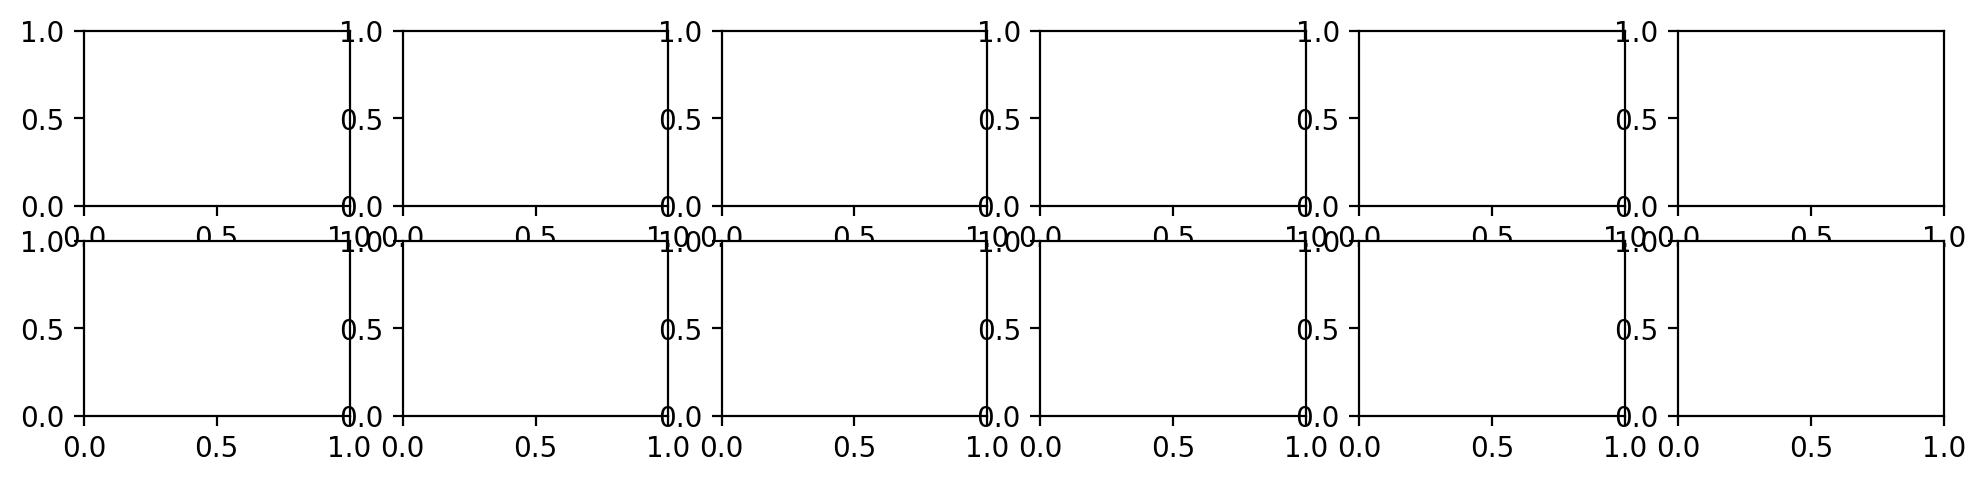

In [4]:
cmap = plt.get_cmap("plasma_r")
color = lambda i: cmap(0.1 + 0.8 * i / (len(6) - 1))

fig, ax = plt.subplots(
    2,
    6,
    figsize=(12, 2.5),
)

map15.show(ax=ax[0][0])
map30.show(ax=ax[0][1])
map45.show(ax=ax[0][2])
map60.show(ax=ax[0][3])
map75.show(ax=ax[0][4])
map90.show(ax=ax[0][5])


ax[1][0].plot(t, flux_true15, color='k', lw=0.6)
# ax[1][0].errorbar(t[sel], flux_obs15[sel], yerr=sigma_flux[sel], fmt='.')

ax[1][1].plot(t, flux_true30, color='k', lw=0.6)
# ax[1][1].errorbar(t[sel], flux_obs30[sel], yerr=sigma_flux[sel], fmt='.')

ax[1][2].plot(t, flux_true45, color='k', lw=0.6)
# ax[1][2].errorbar(t[sel], flux_obs45[sel], yerr=sigma_flux[sel], fmt='.')

ax[1][3].plot(t, flux_true60, color='k', lw=0.6)
# ax[1][3].errorbar(t[sel], flux_obs60[sel], yerr=sigma_flux[sel], fmt='.')

ax[1][4].plot(t, flux_true75, color='k', lw=0.6)
# ax[1][4].errorbar(t[sel], flux_obs75[sel], yerr=sigma_flux[sel], fmt='.')

ax[1][5].plot(t, flux_true90, color='k', lw=0.6)
# ax[1][5].errorbar(t[sel], flux_obs90[sel], yerr=sigma_flux[sel], fmt='.')

for k in range(6):
    if k == 0:
            ax[1, k].spines["top"].set_visible(False)
            ax[1, k].spines["right"].set_visible(False)
            ax[1, k].set_xlabel("time [days]", fontsize=8)
            ax[1, k].set_ylabel("flux [ppt]", fontsize=8)
            for tick in (
                ax[1, k].xaxis.get_major_ticks()
                + ax[1, k].yaxis.get_major_ticks()
            ):
                tick.label.set_fontsize(6)
            ax[1, k].tick_params(direction="in")
    else:
        ax[1, k].axis("off")



In [19]:
t_in[t_in_transit].shape

(280,)

In [18]:
t.shape

(317,)

In [55]:
np.tile([1, 0.5], 2)

array([1. , 0.5, 1. , 0.5])

In [61]:
[1]+[0.5]*7

[1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_32256/1899915288.py:118: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(6)
/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_32256/1899915288.py:134: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(6)
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing

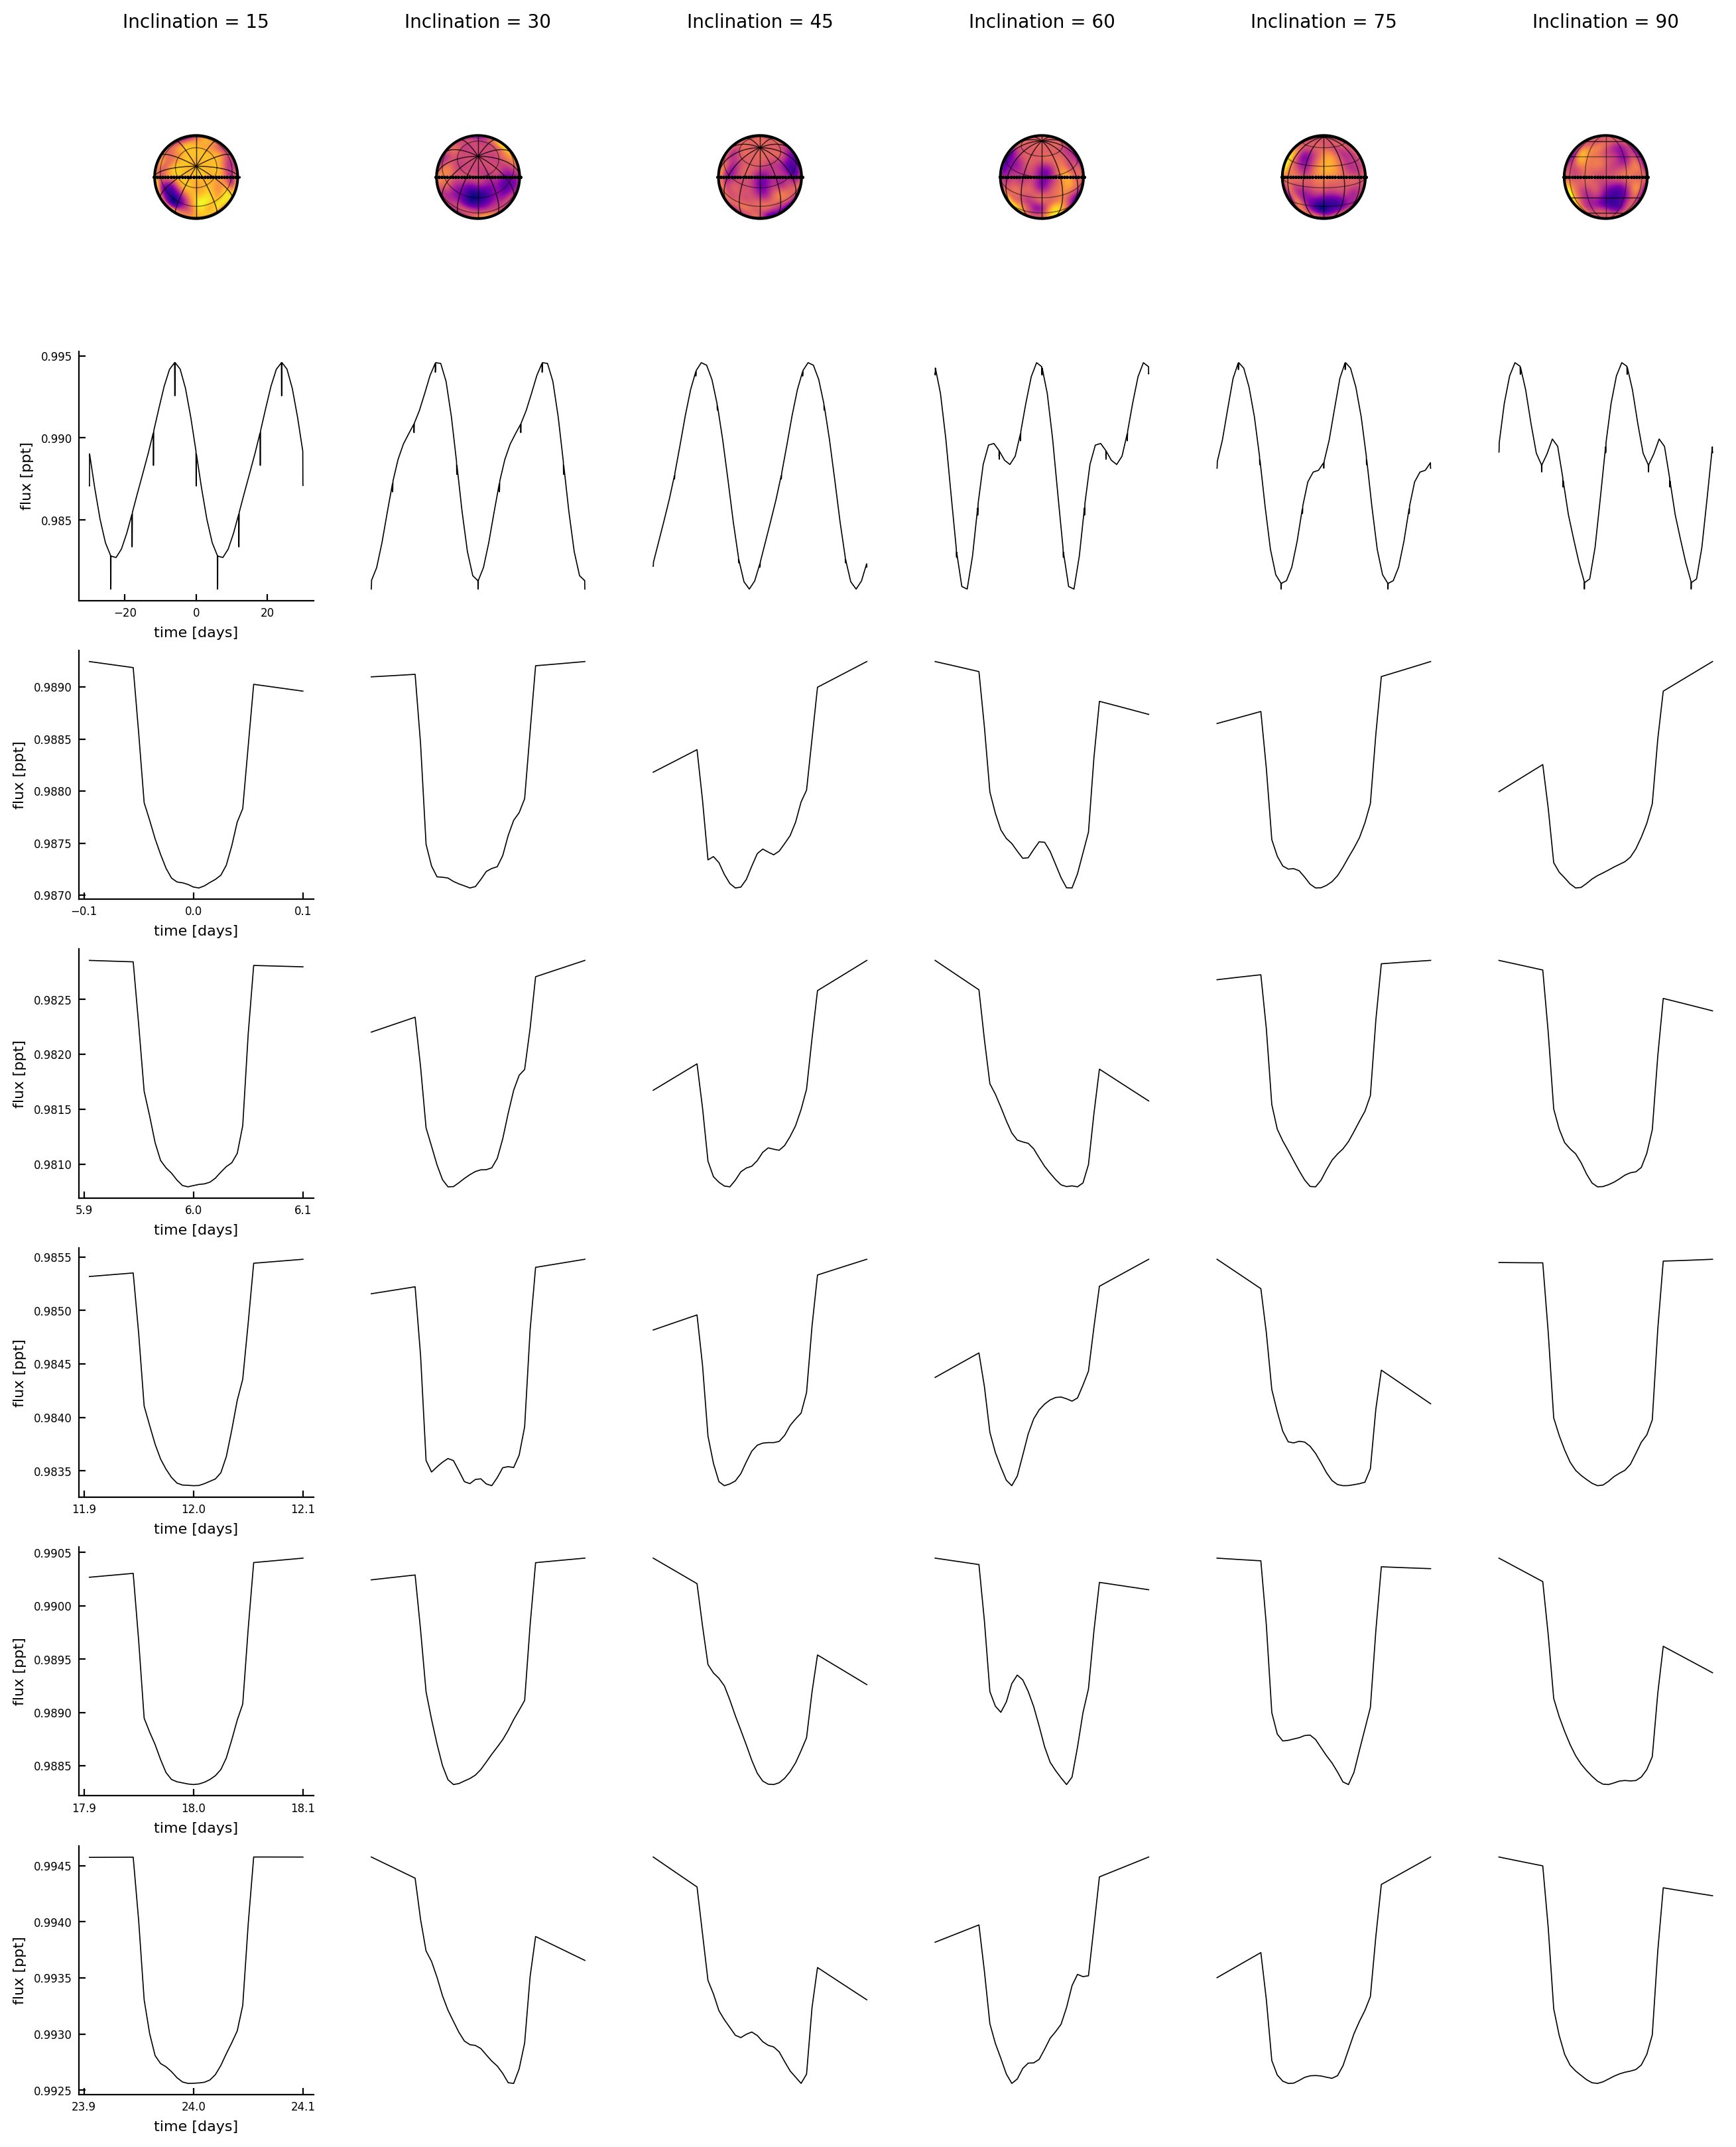

In [79]:
starry.config.lazy = True
incs = [15,30,45,60,75,90]

ydeg = 15
udeg = 2

u1 = 0.4
u2 = 0.26

r = 20.0
dr = 5.0
n = 2
c = 0.5
mu = 30.0
sigma = 5.0

prot = 30.0
porb = 6.0

stellar_obl = 0.0

rng = np.random.default_rng(302592346730275158208684369480422136411)

Ttr_half = 0.1
dt_in_transit = Ttr_half / 20.0
dt_out_transit = prot / 20.0

T = 1*prot
t_in = np.arange(-T, T, dt_in_transit)
t_out = np.arange(-T, T, dt_out_transit)

t_in_transit = (t_in % sec.porb.eval() < Ttr_half) | (t_in % sec.porb.eval() > sec.porb.eval()-Ttr_half)
t_out_transit = (t_out % sec.porb.eval() < Ttr_half) | (t_out % sec.porb.eval() > sec.porb.eval()-Ttr_half)

t = np.sort(np.concatenate((
    t_in[t_in_transit],
    t_out[~t_out_transit],
)))
nt = len(t)
idx = np.zeros(len(t), dtype=bool)
ntransits = int(np.ceil(t[-1] / porb))
for n in range(ntransits):
        t0 = 0 + n * porb
        idx |= ((t > t0 - dt_in_transit) & (t < t0 + dt_in_transit))

cmap = plt.get_cmap("plasma_r")
color = lambda i: cmap(0.1 + 0.8 * i / (len(6) - 1))

fig, ax = plt.subplots(
    # 2+ntransits,
    2+ntransits,
    len(incs),
    figsize=(16, 20),
    # gridspec_kw={
    #     "height_ratios": [2]+[0.5]*8,
    #     "width_ratios": [2]*len(incs),
    # },
)

for k in range(len(incs)):
    pri = Primary(starry.Map(ydeg, udeg=udeg, inc=incs[k], obl=stellar_obl),
              r=0.683, m=0.81, prot=prot, t0=0.0)

    sec = Secondary(starry.Map(0, 0), 
                    t0=0, r=0.04*pri.r.eval(), m=1e-3*pri.m.eval(), prot=1.0,
                    porb=porb, ecc=0.0, Omega=0, inc=90)
    pri.map[1] = u1
    pri.map[2] = u2

    sys = System(pri, sec)

    Ttr_half = 0.1
    dt_in_transit = Ttr_half / 20.0
    dt_out_transit = prot / 20.0

    sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=r, dr=dr, ydeg=ydeg, udeg=udeg, marginalize_over_inclination=False, seed=rng.integers(0, 1<<32))

    y_true = sp.sample_ylm().eval()[0,:]
    y_true[0] = 1.0

    flux_true = sys.design_matrix(t).eval()[:, :-1] @ y_true
    sigma_flux = 1e-4*np.ones_like(flux_true)

    flux_obs = flux_true + sigma_flux*rng.normal(size=nt)

    # ssp = StarryStarryProcess(sys, sp, nt, len(pri.map.y.eval()))

    map_true = starry.Map(ydeg, udeg=udeg, inc=incs[k], obl=stellar_obl)
    map_true[:,:] = y_true
    map_true.show(ax=ax[0][k]) 

    xo, yo, zo = sys.position(t)
    xo = xo[1].eval()
    yo = yo[1].eval()
    zo = zo[1].eval()
        
    idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
    ax[0][k].plot(xo[idx], yo[idx], "k.", ms=1);
    ax[0][k].set_aspect(1)
    ax[0][k].set_ylim(-3, 3)

    ax[1][k].plot(t, flux_true, color='k', lw=0.6)

    for i in range(ntransits):
        idx = (t > sec.t0.eval()+i*porb-0.1) &  (t<sec.t0.eval()+i*porb+0.1)
        ax[i+2][k].plot(t[idx], flux_true[idx], color='k', lw=0.6)
 

    if k == 0:
            ax[1, k].spines["top"].set_visible(False)
            ax[1, k].spines["right"].set_visible(False)
            ax[1, k].set_xlabel("time [days]", fontsize=8)
            ax[1, k].set_ylabel("flux [ppt]", fontsize=8)
            for tick in (
                ax[1, k].xaxis.get_major_ticks()
                + ax[1, k].yaxis.get_major_ticks()
            ):
                tick.label.set_fontsize(6)
            ax[1, k].tick_params(direction="in")
    else:
        ax[1, k].axis("off")


    for i in range(ntransits):
        if k == 0:
                ax[i+2, k].spines["top"].set_visible(False)
                ax[i+2, k].spines["right"].set_visible(False)
                ax[i+2, k].set_xlabel("time [days]", fontsize=8)
                ax[i+2, k].set_ylabel("flux [ppt]", fontsize=8)
                for tick in (
                    ax[i+2, k].xaxis.get_major_ticks()
                    + ax[i+2, k].yaxis.get_major_ticks()
                ):
                    tick.label.set_fontsize(6)
                ax[i+2, k].tick_params(direction="in")
        else:
            ax[i+2, k].axis("off")

    ax[0, k].text(0.5, 1.1, f"Inclination = {incs[k]}", transform=ax[0, k].transAxes,
                 fontsize=10, ha='center')


In [36]:
sec.t0.eval()-dt_in_transit

-0.005

In [38]:
dt_out_transit

1.5

In [47]:
sec.t0.eval()+1.5-0.1

1.4

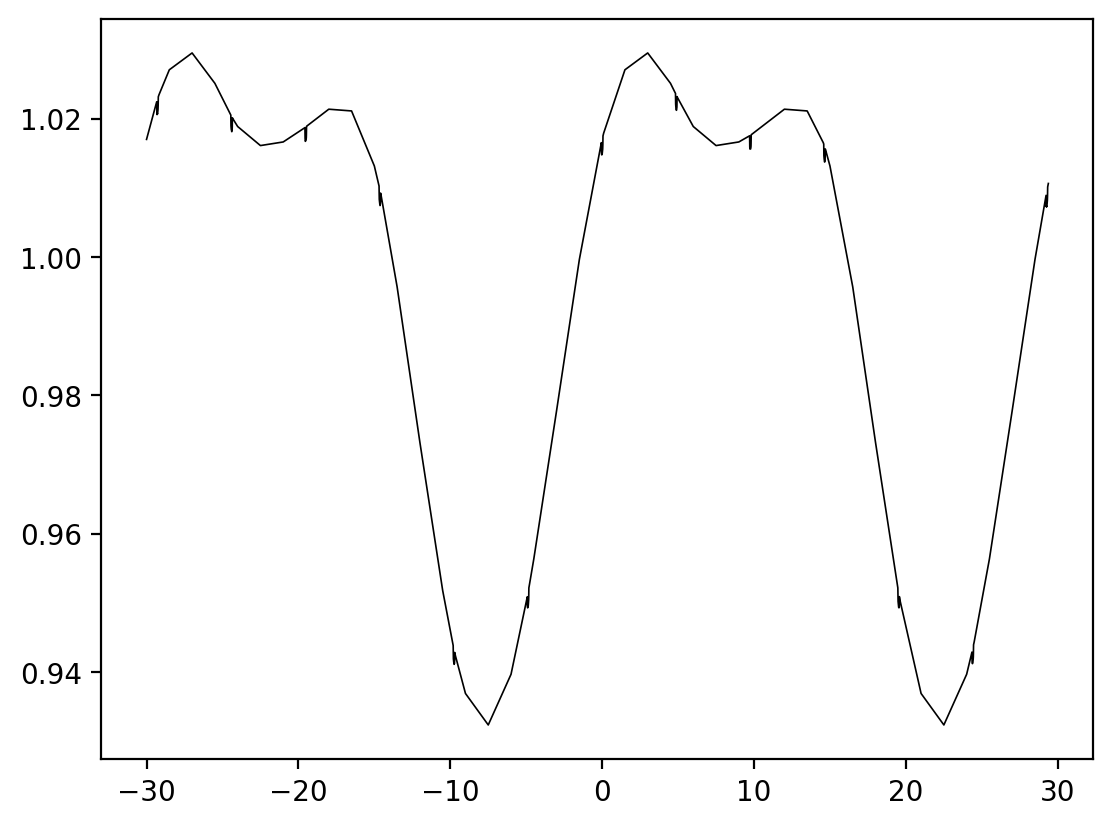

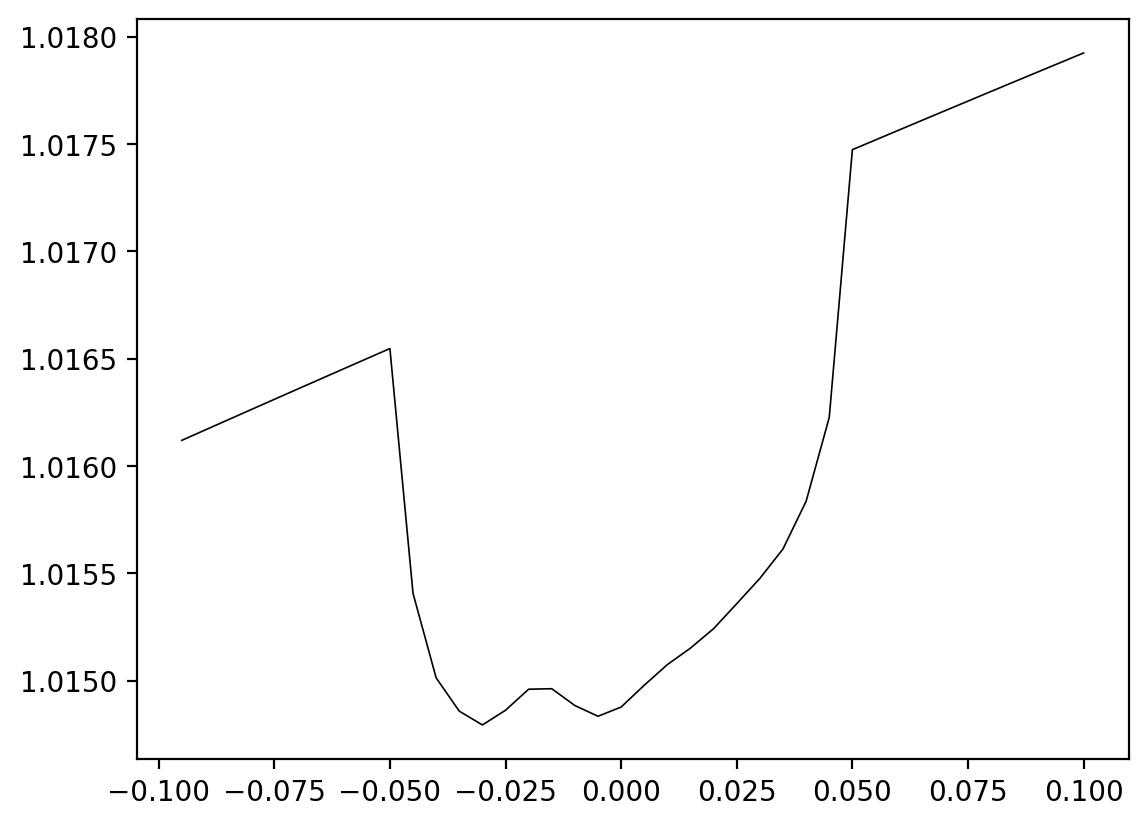

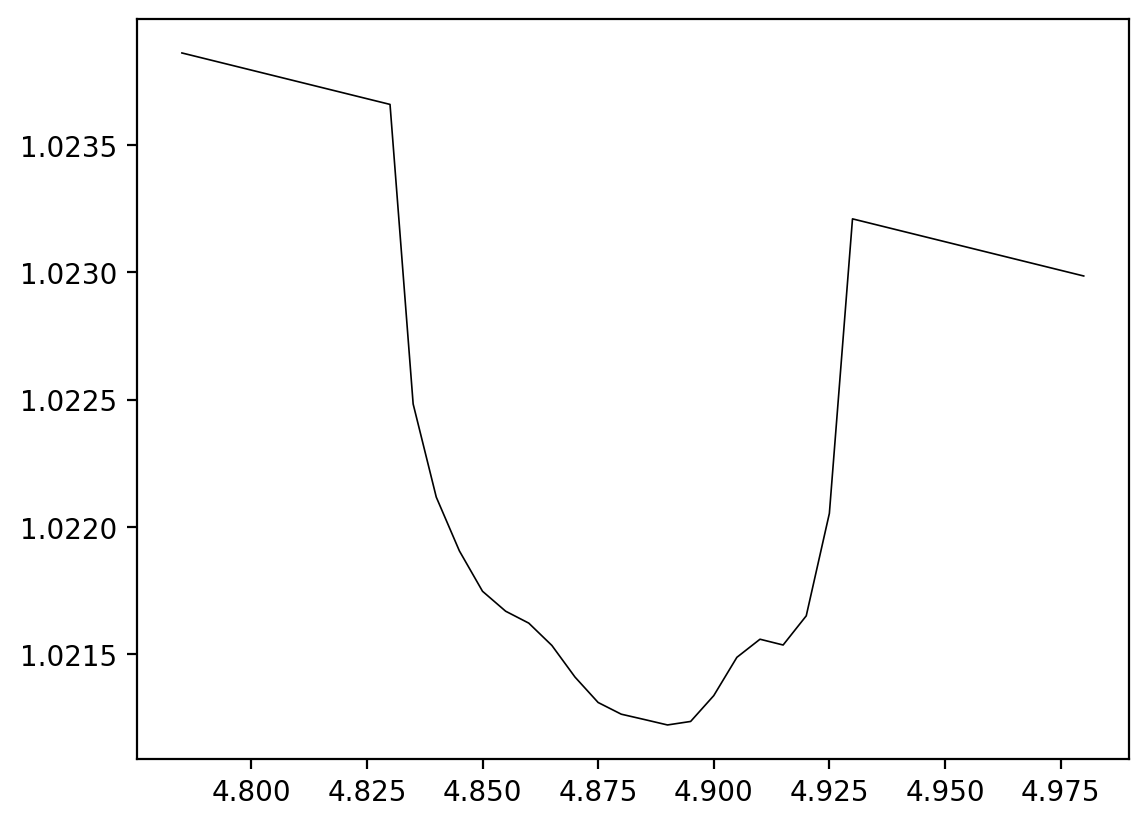

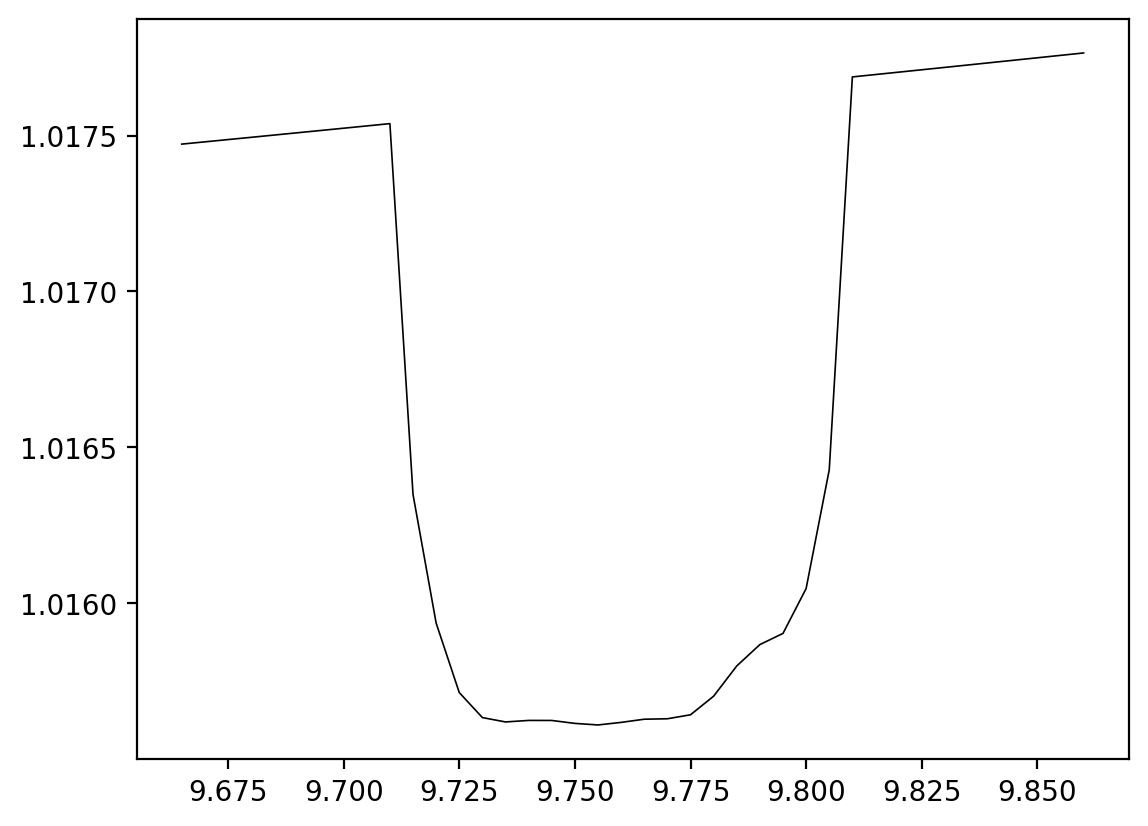

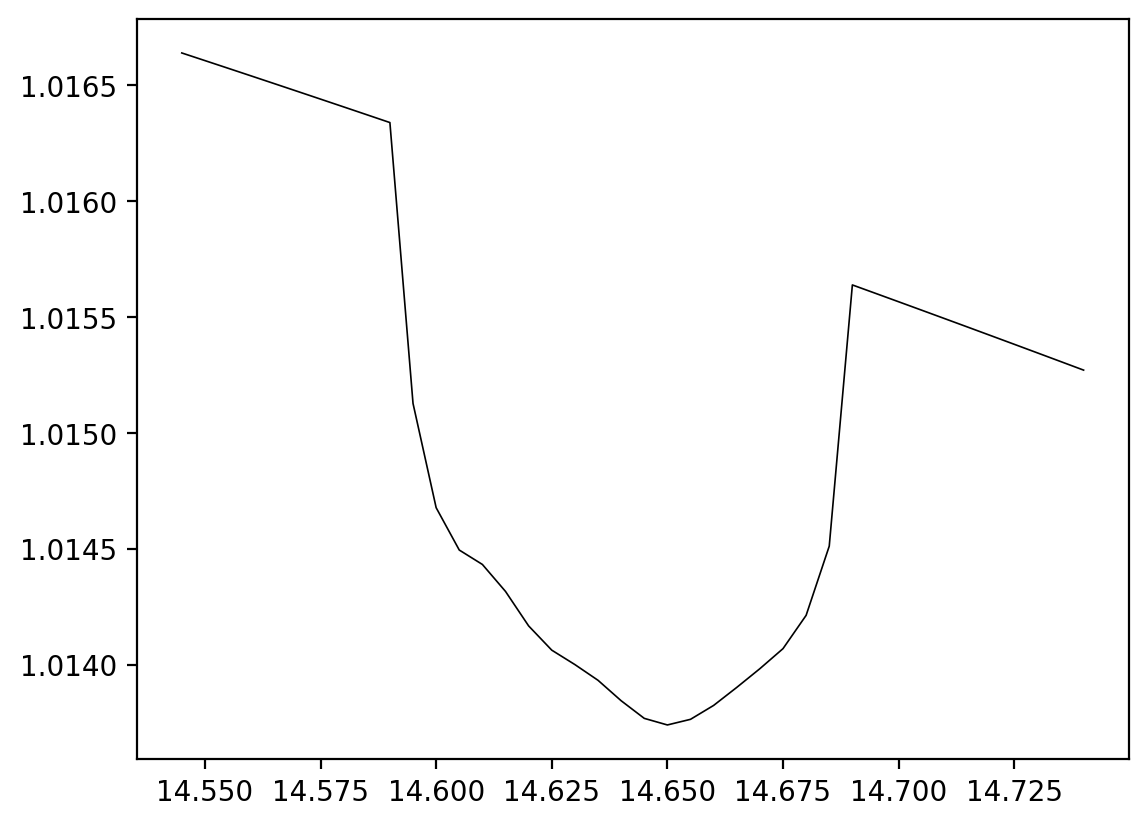

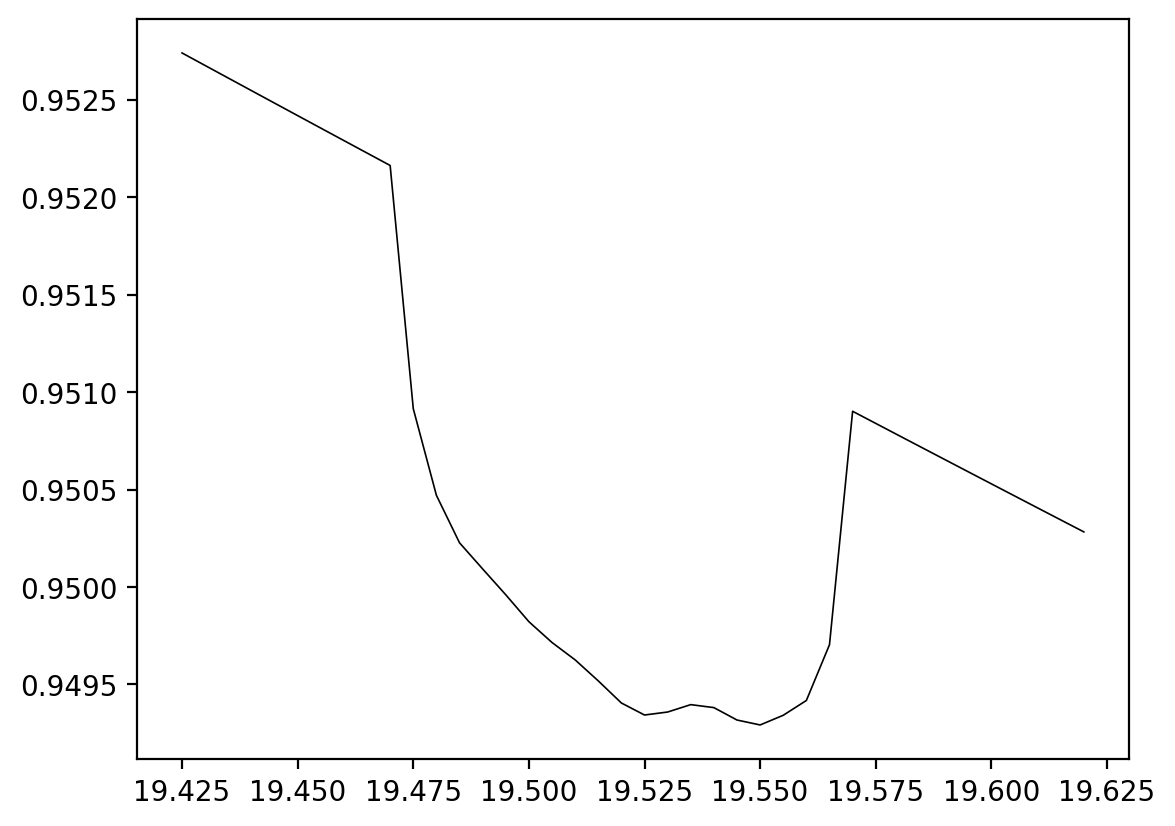

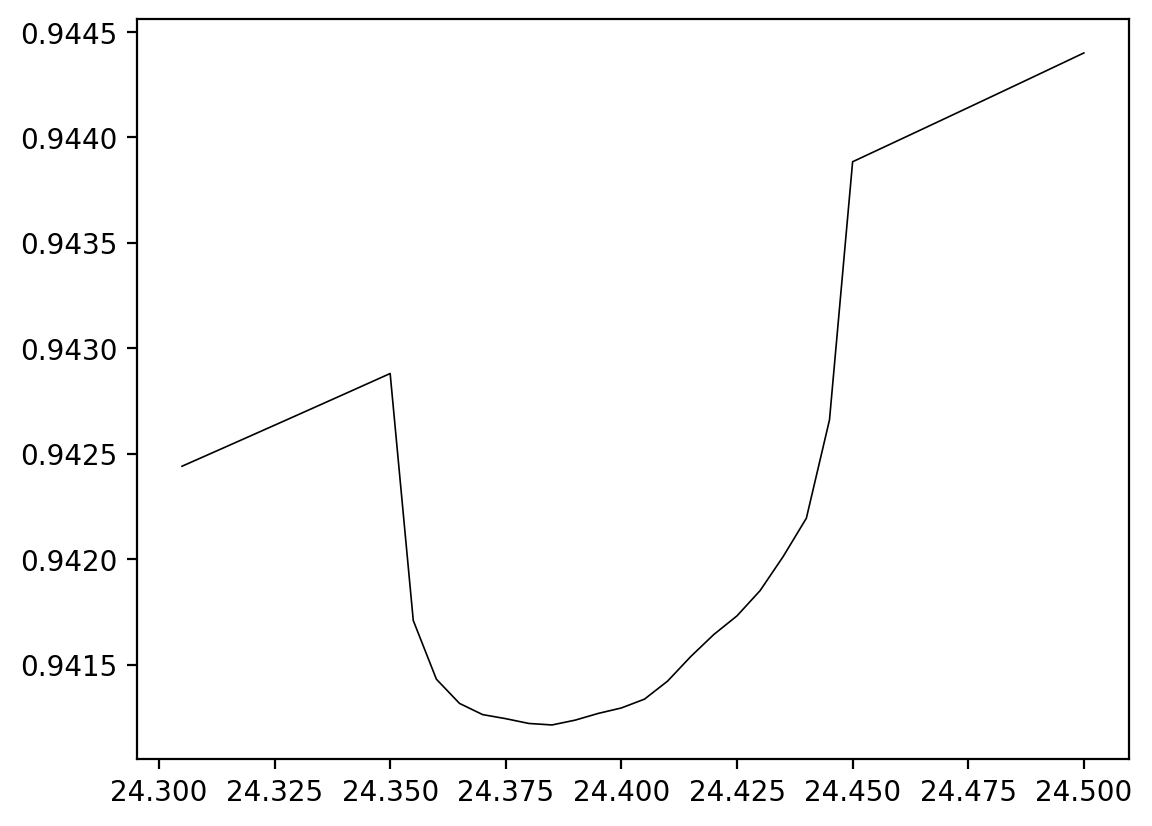

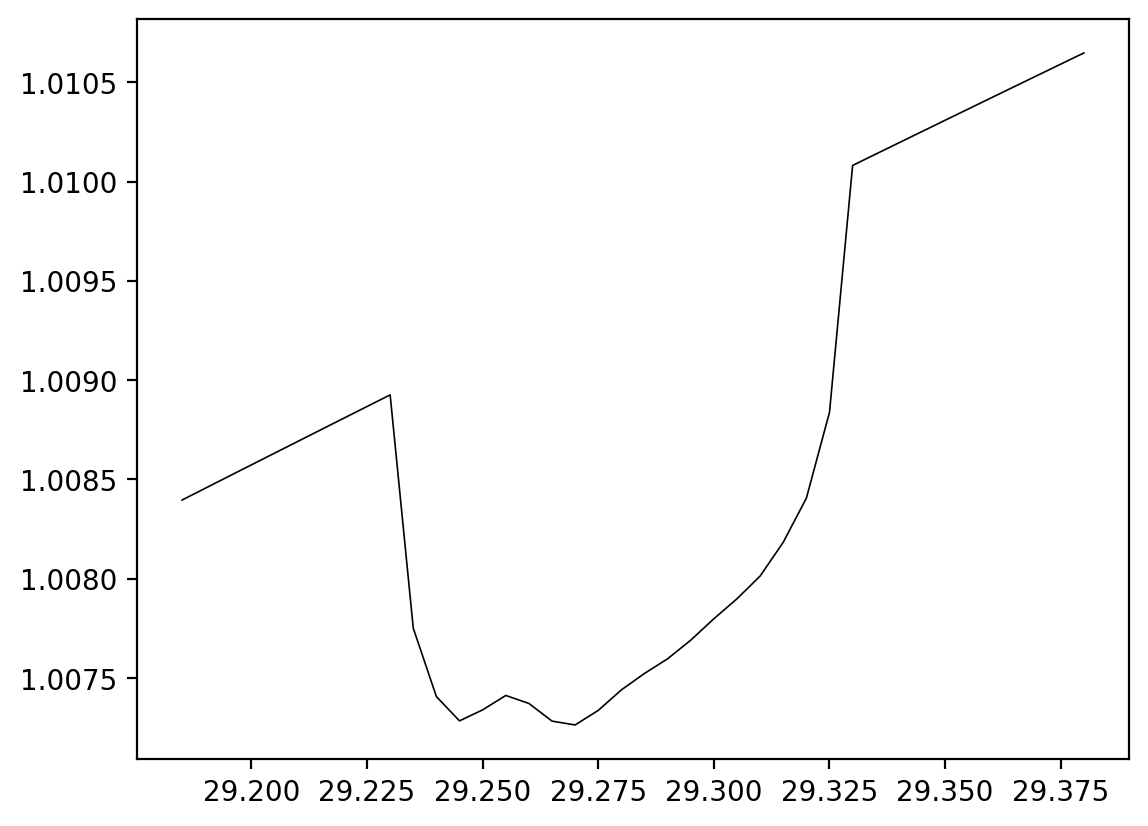

In [51]:
plt.plot(t, flux_true, color='k', lw=0.6)
plt.show()
idx = (t > sec.t0.eval()-0.1) &  (t<sec.t0.eval()+0.1)
plt.plot(t[idx], flux_true[idx], color='k', lw=0.6)
# plt.xlim(sec.t0.eval()-0.1, sec.t0.eval()+0.1)
plt.show()
idx = (t > sec.t0.eval()+porb-0.1) &  (t<sec.t0.eval()+porb+0.1)
plt.plot(t[idx], flux_true[idx], color='k', lw=0.6)
plt.show()
idx = (t > sec.t0.eval()+2*porb-0.1) &  (t<sec.t0.eval()+2*porb+0.1)
plt.plot(t[idx], flux_true[idx], color='k', lw=0.6)
plt.show()
idx = (t > sec.t0.eval()+3*porb-0.1) &  (t<sec.t0.eval()+3*porb+0.1)
plt.plot(t[idx], flux_true[idx], color='k', lw=0.6)
plt.show()
idx = (t > sec.t0.eval()+4*porb-0.1) &  (t<sec.t0.eval()+4*porb+0.1)
plt.plot(t[idx], flux_true[idx], color='k', lw=0.6)
plt.show()
idx = (t > sec.t0.eval()+5*porb-0.1) &  (t<sec.t0.eval()+5*porb+0.1)
plt.plot(t[idx], flux_true[idx], color='k', lw=0.6)
plt.show()
idx = (t > sec.t0.eval()+6*porb-0.1) &  (t<sec.t0.eval()+6*porb+0.1)
plt.plot(t[idx], flux_true[idx], color='k', lw=0.6)
plt.show()

In [71]:
ntransits

19

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_32256/3787327217.py:119: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(6)
/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_32256/3787327217.py:134: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(6)
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing

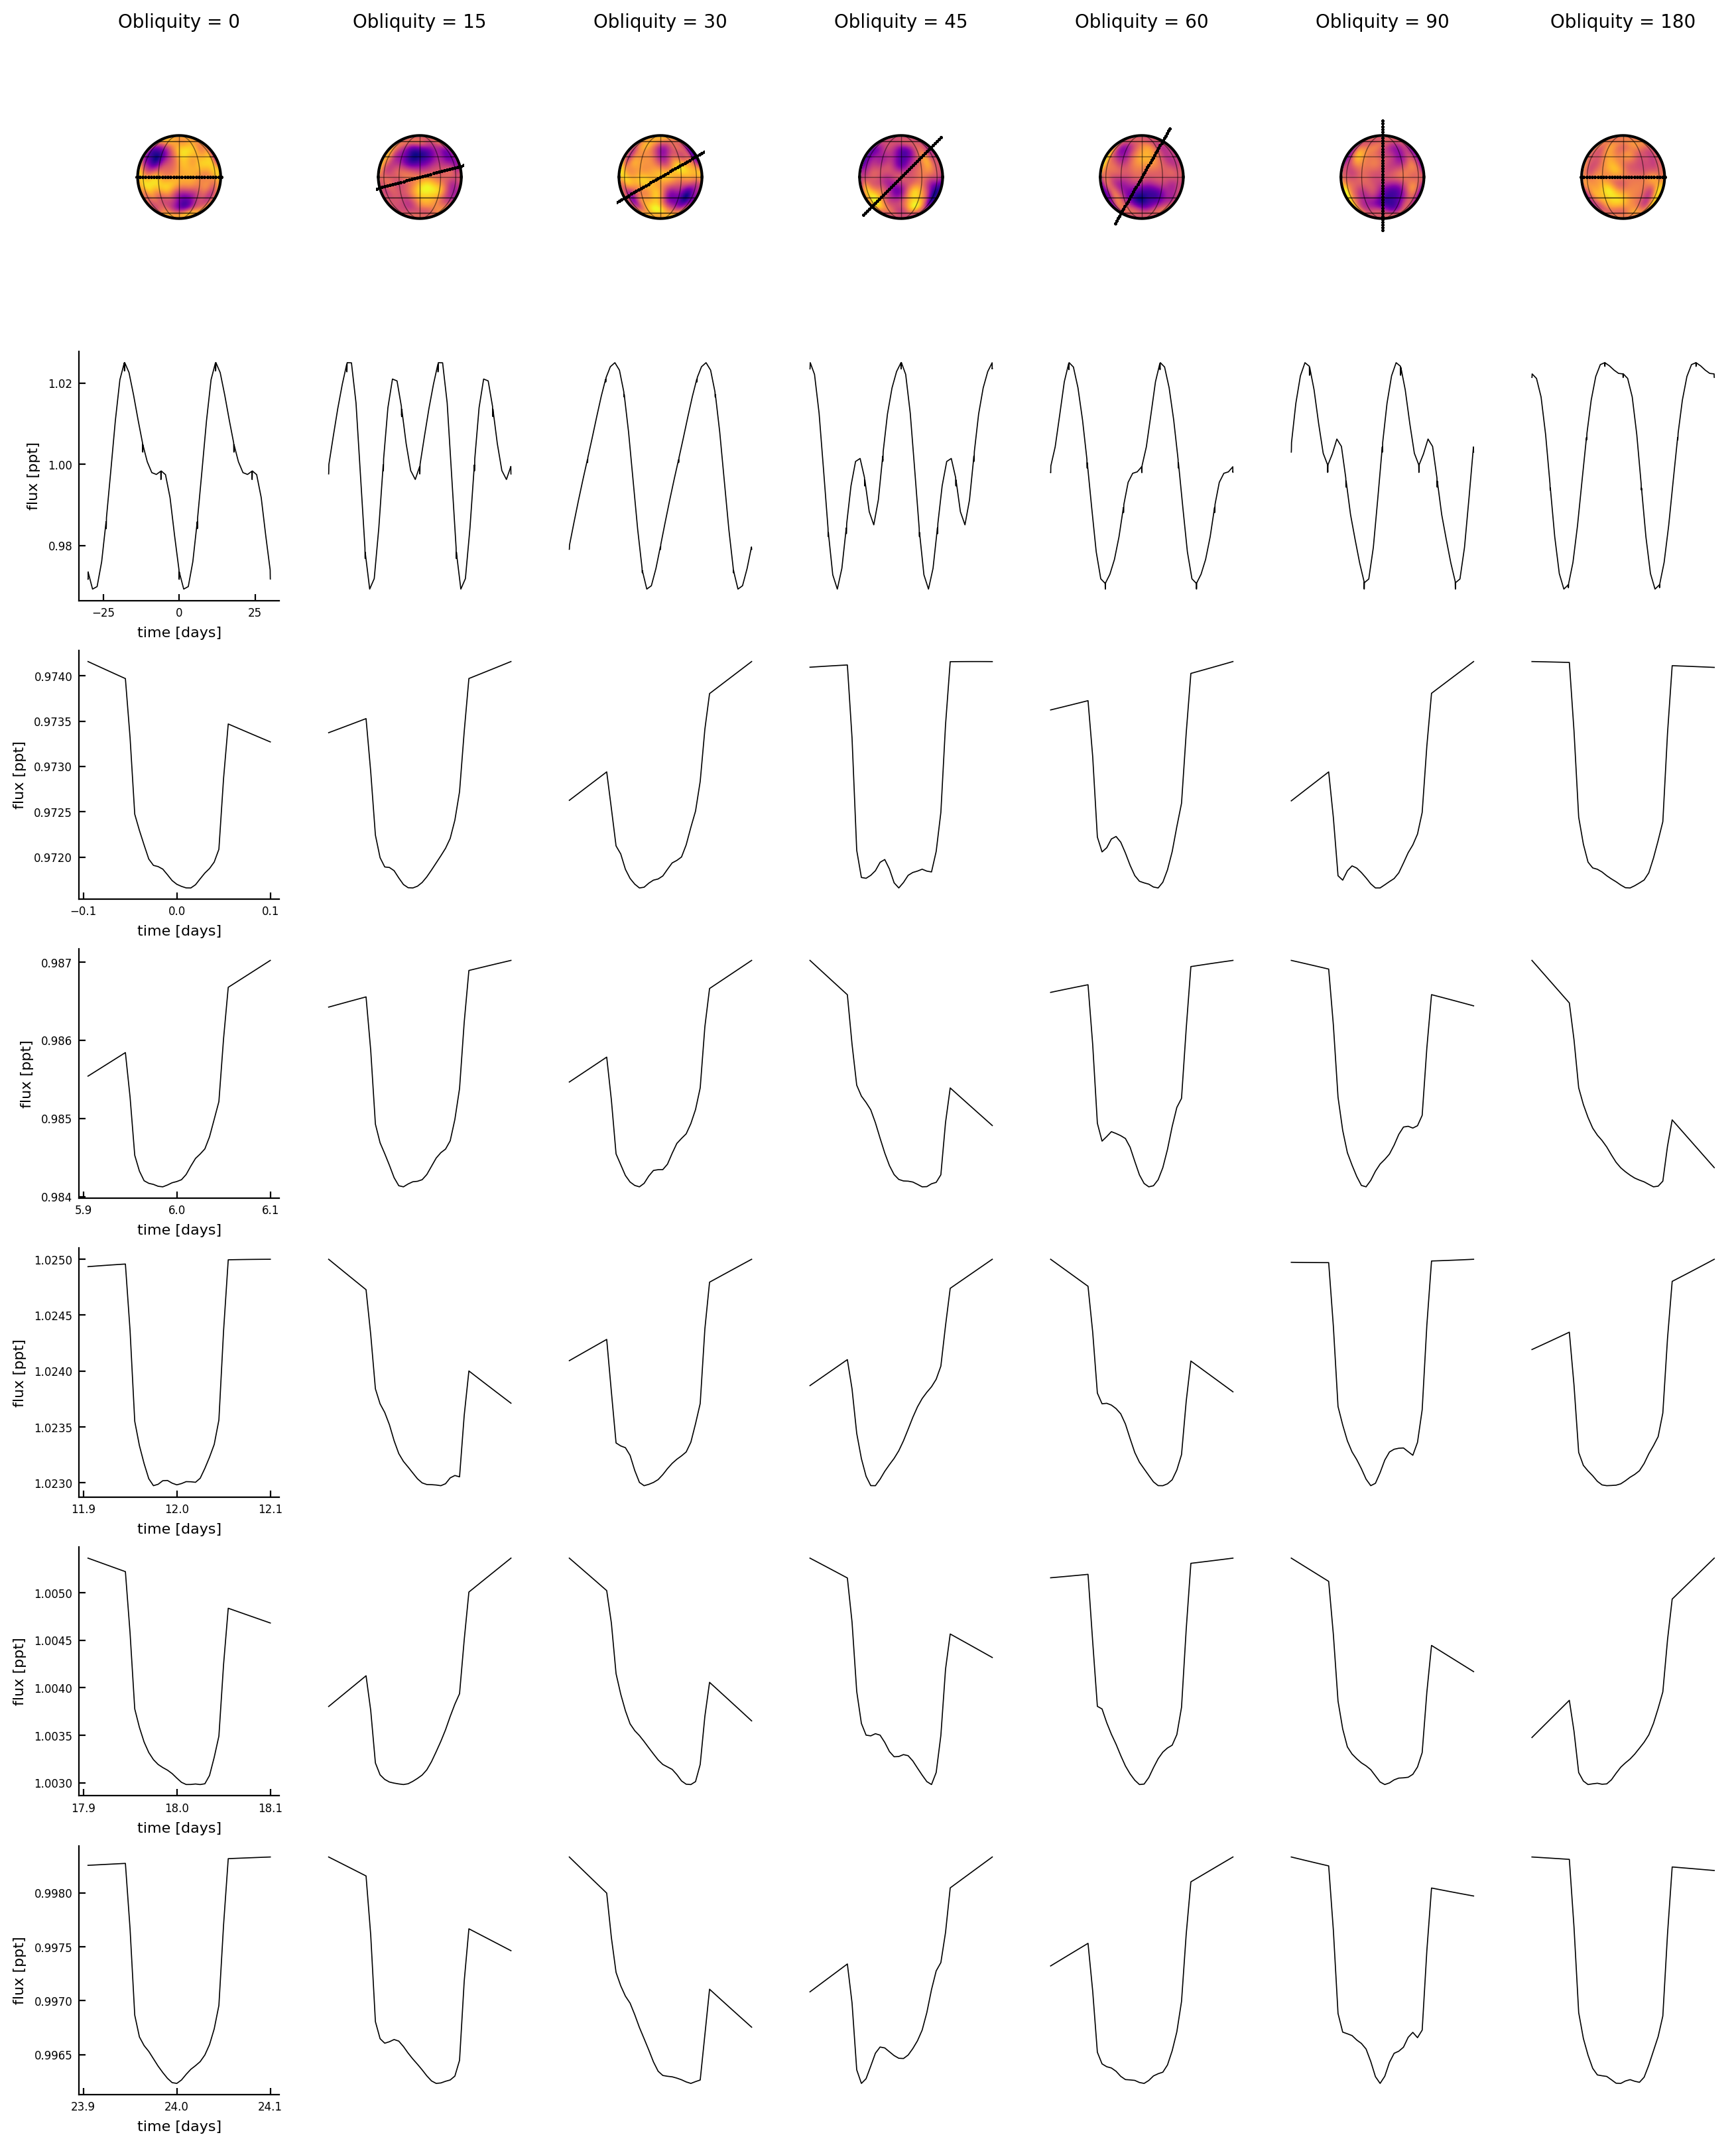

In [78]:
starry.config.lazy = True
obls = [0,15,30,45,60,90,180]

ydeg = 15
udeg = 2

u1 = 0.4
u2 = 0.26

r = 20.0
dr = 5.0
n = 2
c = 0.5
mu = 30.0
sigma = 5.0

prot = 30.0
porb = 6.0

stellar_inc = 90.0

rng = np.random.default_rng(302592346730275158208684369480422136411)

Ttr_half = 0.1
dt_in_transit = Ttr_half / 20.0
dt_out_transit = prot / 20.0

T = 1*prot
t_in = np.arange(-T, T, dt_in_transit)
t_out = np.arange(-T, T, dt_out_transit)

t_in_transit = (t_in % sec.porb.eval() < Ttr_half) | (t_in % sec.porb.eval() > sec.porb.eval()-Ttr_half)
t_out_transit = (t_out % sec.porb.eval() < Ttr_half) | (t_out % sec.porb.eval() > sec.porb.eval()-Ttr_half)

t = np.sort(np.concatenate((
    t_in[t_in_transit],
    t_out[~t_out_transit],
)))
nt = len(t)
idx = np.zeros(len(t), dtype=bool)
ntransits = int(np.ceil(t[-1] / porb))
for n in range(ntransits):
        t0 = 0 + n * porb
        idx |= ((t > t0 - dt_in_transit) & (t < t0 + dt_in_transit))

cmap = plt.get_cmap("plasma_r")
color = lambda i: cmap(0.1 + 0.8 * i / (len(6) - 1))

fig, ax = plt.subplots(
    # 2+ntransits,
    2+ntransits,
    len(obls),
    figsize=(16, 20),
    # gridspec_kw={
    #     "height_ratios": [2]+[0.5]*8,
    #     "width_ratios": [2]*len(incs),
    # },
)

for k in range(len(obls)):
    pri = Primary(starry.Map(ydeg, udeg=udeg, inc=90.0),
              r=0.683, m=0.81, prot=prot, t0=0.0)

    sec = Secondary(starry.Map(0, 0), 
                    t0=0, r=0.04*pri.r.eval(), m=1e-3*pri.m.eval(), prot=1.0,
                    porb=porb, ecc=0.0, Omega=obls[k], inc=90)
    pri.map[1] = u1
    pri.map[2] = u2

    sys = System(pri, sec)

    Ttr_half = 0.1
    dt_in_transit = Ttr_half / 20.0
    dt_out_transit = prot / 20.0

    sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=r, dr=dr, ydeg=ydeg, udeg=udeg, marginalize_over_inclination=False, seed=rng.integers(0, 1<<32))

    y_true = sp.sample_ylm().eval()[0,:]
    y_true[0] = 1.0

    flux_true = sys.design_matrix(t).eval()[:, :-1] @ y_true
    sigma_flux = 1e-4*np.ones_like(flux_true)

    flux_obs = flux_true + sigma_flux*rng.normal(size=nt)

    # ssp = StarryStarryProcess(sys, sp, nt, len(pri.map.y.eval()))

    map_true = starry.Map(ydeg, udeg=udeg, inc=90.0, obl=0.0)
    map_true[:,:] = y_true
    map_true.show(ax=ax[0][k]) 

    xo, yo, zo = sys.position(t)
    xo = xo[1].eval()
    yo = yo[1].eval()
    zo = zo[1].eval()
        
    idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
    ax[0][k].plot(xo[idx], yo[idx], "k.", ms=1);
    ax[0][k].set_aspect(1)
    ax[0][k].set_ylim(-3, 3)

    ax[1][k].plot(t, flux_true, color='k', lw=0.6)

    for i in range(ntransits):

        idx = (t > sec.t0.eval()+i*porb-0.1) &  (t<sec.t0.eval()+i*porb+0.1)
        ax[i+2][k].plot(t[idx], flux_true[idx], color='k', lw=0.6)
    

    if k == 0:
            ax[1, k].spines["top"].set_visible(False)
            ax[1, k].spines["right"].set_visible(False)
            ax[1, k].set_xlabel("time [days]", fontsize=8)
            ax[1, k].set_ylabel("flux [ppt]", fontsize=8)
            for tick in (
                ax[1, k].xaxis.get_major_ticks()
                + ax[1, k].yaxis.get_major_ticks()
            ):
                tick.label.set_fontsize(6)
            ax[1, k].tick_params(direction="in")
    else:
        ax[1, k].axis("off")

    for i in range(ntransits):
        if k == 0:
                ax[i+2, k].spines["top"].set_visible(False)
                ax[i+2, k].spines["right"].set_visible(False)
                ax[i+2, k].set_xlabel("time [days]", fontsize=8)
                ax[i+2, k].set_ylabel("flux [ppt]", fontsize=8)
                for tick in (
                    ax[i+2, k].xaxis.get_major_ticks()
                    + ax[i+2, k].yaxis.get_major_ticks()
                ):
                    tick.label.set_fontsize(6)
                ax[i+2, k].tick_params(direction="in")
        else:
            ax[i+2, k].axis("off")
            
    # Add annotation above each column
    ax[0, k].text(0.5, 1.1, f"Obliquity = {obls[k]}", transform=ax[0, k].transAxes,
                 fontsize=10, ha='center')

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_12061/3668234453.py:107: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(6)
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Pre-computing some m

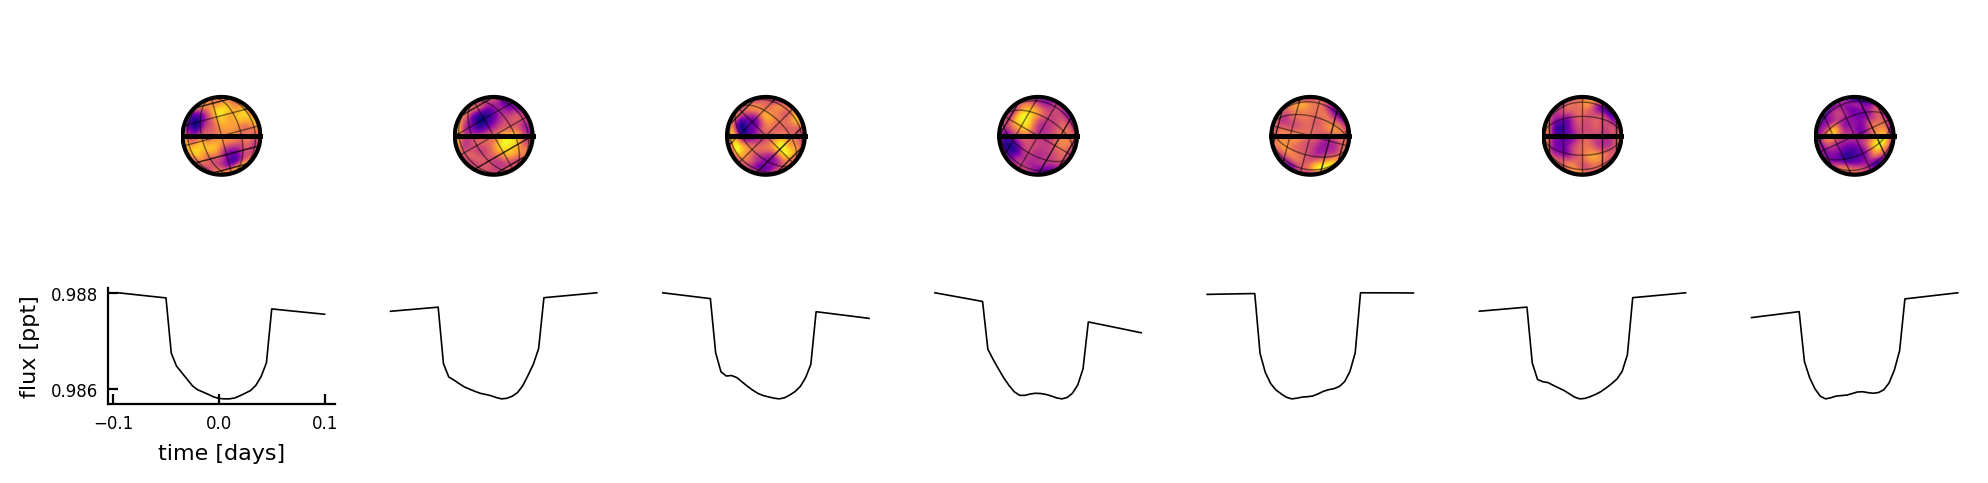

In [70]:
starry.config.lazy = True
obls = [15,30,45,60,75,90,115]

ydeg = 15
udeg = 2

u1 = 0.4
u2 = 0.26

r = 20.0
dr = 5.0
n = 1
c = 0.5
mu = 30.0
sigma = 5.0

prot = 30.0
porb = 4.887802443

stellar_inc = 90.0

rng = np.random.default_rng(302592346730275158208684369480422136411)

Ttr_half = 0.1
dt_in_transit = Ttr_half / 20.0
dt_out_transit = prot / 20.0

T = 3*prot
t_in = np.arange(-T, T, dt_in_transit)
t_out = np.arange(-T, T, dt_out_transit)

t_in_transit = (t_in % sec.porb.eval() < Ttr_half) | (t_in % sec.porb.eval() > sec.porb.eval()-Ttr_half)
t_out_transit = (t_out % sec.porb.eval() < Ttr_half) | (t_out % sec.porb.eval() > sec.porb.eval()-Ttr_half)

t = np.sort(np.concatenate((
    t_in[t_in_transit],
    t_out[~t_out_transit],
)))
nt = len(t)

cmap = plt.get_cmap("plasma_r")
color = lambda i: cmap(0.1 + 0.8 * i / (len(6) - 1))

fig, ax = plt.subplots(
    2,
    len(obls),
    figsize=(12, 2.5),
    gridspec_kw={
        "height_ratios": np.tile([1, 0.5], 1),
        # "width_ratios": np.append(np.ones(5), 0.1),
    },
)

for k in range(len(obls)):
    pri = Primary(starry.Map(ydeg, udeg=udeg, inc=stellar_inc, obl=obls[k]),
              r=0.683, m=0.81, prot=prot, t0=0.0)

    sec = Secondary(starry.Map(0, 0), 
                    t0=0, r=0.04*pri.r.eval(), m=1e-3*pri.m.eval(), prot=1.0,
                    porb=porb, ecc=0.0, Omega=0.0, inc=90)
    pri.map[1] = u1
    pri.map[2] = u2

    sys = System(pri, sec)

    Ttr_half = 0.1
    dt_in_transit = Ttr_half / 20.0
    dt_out_transit = prot / 20.0

    sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=r, dr=dr, ydeg=ydeg, udeg=udeg, marginalize_over_inclination=False, seed=rng.integers(0, 1<<32))

    y_true = sp.sample_ylm().eval()[0,:]
    y_true[0] = 1.0

    flux_true = sys.design_matrix(t).eval()[:, :-1] @ y_true
    sigma_flux = 1e-4*np.ones_like(flux_true)

    flux_obs = flux_true + sigma_flux*rng.normal(size=nt)

    # ssp = StarryStarryProcess(sys, sp, nt, len(pri.map.y.eval()))

    map_true = starry.Map(ydeg, udeg=udeg, inc=stellar_inc, obl=obls[k])
    map_true[:,:] = y_true
    map_true.show(ax=ax[0][k]) 

    xo, yo, zo = sys.position(t)
    xo = xo[1].eval()
    yo = yo[1].eval()
    zo = zo[1].eval()
        
    idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
    ax[0][k].plot(xo[idx], yo[idx], "k.", ms=1);
    ax[0][k].set_aspect(1)
    ax[0][k].set_ylim(-3, 3)

    ax[1][k].plot(t[sel], flux_true[sel], color='k', lw=0.6)

    if k == 0:
            ax[1, k].spines["top"].set_visible(False)
            ax[1, k].spines["right"].set_visible(False)
            ax[1, k].set_xlabel("time [days]", fontsize=8)
            ax[1, k].set_ylabel("flux [ppt]", fontsize=8)
            for tick in (
                ax[1, k].xaxis.get_major_ticks()
                + ax[1, k].yaxis.get_major_ticks()
            ):
                tick.label.set_fontsize(6)
            ax[1, k].tick_params(direction="in")
    else:
        ax[1, k].axis("off")
